# L2 Softmax Loss
L2 Softmax Lossを用いてmetiric learningを行う。
mninst datasetに対して、Neural Networkで特徴空間にmapし、距離関数で手書き文字の相違を判定させる。
通常の分類タスクでよく用いられるSoftmax Lossはmetric learningでも使われるようなので、L2 Softmax Lossと比較することにする。

## 特徴
- 実装が簡単。よく用いられるsoftmax lossを少し修正するだけでよい。特別なlossは必要ないため非常に手軽に試せる
- 似ているもののcosine similarityは大きく、異なるものは小さくなるように学習する

## 表式
最終層の出力にL2 normalization -> scale変換 -> softmax layerを施し、cross-entropyをloss関数とし、学習する。推論時はL2 normalization以下を省くことで入力画像が特徴空間にmapされる。2つの入力を特徴空間にmapし、cosine similarityを求める。ある閾値を超えた場合、2つの入力が同一であると判定する。


In [3]:
from keras.datasets import mnist
import warnings
warnings.filterwarnings('ignore')

In [4]:
mnist.load_data()
print('success')

success


In [5]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras import backend as K
import numpy as np

In [6]:
# set const
batch_size = 128
num_classes = 10
epochs = 10
# input image dimensions
img_rows, img_cols = 28, 28

In [7]:
def make_dataset(img_rows, img_cols, num_classes):
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, x_test, y_train, y_test, input_shape

### define and fit model with L2 softmax Loss

In [8]:
def make_model(input_shape, num_classes, alpha=0.3):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    # l2 softmax
    model.add(Dense(128, activation='linear', 
                                    activity_regularizer=regularizers.l2(alpha)
                   ))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [10]:
'''
Trains a simple convnet on the MNIST dataset.
'''

x_train, x_test, y_train, y_test, input_shape = make_dataset(img_rows, img_cols, num_classes)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

model = make_model(input_shape, num_classes, alpha=0.01)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

In [233]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 158s 3ms/step - loss: 1.3550 - acc: 0.9204 - val_loss: 0.7465 - val_acc: 0.9796
Epoch 2/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.5963 - acc: 0.9813 - val_loss: 0.4743 - val_acc: 0.9861
Epoch 3/10
60000/60000 [==============================] - 138s 2ms/step - loss: 0.4211 - acc: 0.9868 - val_loss: 0.3612 - val_acc: 0.9888
Epoch 4/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.3436 - acc: 0.9898 - val_loss: 0.3172 - val_acc: 0.9894
Epoch 5/10
60000/60000 [==============================] - 139s 2ms/step - loss: 0.2975 - acc: 0.9917 - val_loss: 0.2771 - val_acc: 0.9904
Epoch 6/10
60000/60000 [==============================] - 141s 2ms/step - loss: 0.2665 - acc: 0.9931 - val_loss: 0.2570 - val_acc: 0.9904
Epoch 7/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.2438 - acc: 0.9940 - val_loss: 0.2435 - 

In [254]:
model.save_weights("model_L2softmaxLoss.h5")

In [11]:
model.load_weights("model_L2softmaxLoss.h5")

### define and fit base model

In [11]:
def make_basemodel(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [12]:
basemodel = make_basemodel(input_shape, num_classes)

basemodel.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
basemodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = basemodel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.1761 - acc: 0.9469 - val_loss: 0.0649 - val_acc: 0.9802
Epoch 2/10
60000/60000 [==============================] - 99s 2ms/step - loss: 0.0603 - acc: 0.9816 - val_loss: 0.0540 - val_acc: 0.9816
Epoch 3/10
60000/60000 [==============================] - 94s 2ms/step - loss: 0.0443 - acc: 0.9869 - val_loss: 0.0461 - val_acc: 0.9850
Epoch 4/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0366 - acc: 0.9889 - val_loss: 0.0350 - val_acc: 0.9881
Epoch 5/10
60000/60000 [==============================] - 100s 2ms/step - loss: 0.0301 - acc: 0.9904 - val_loss: 0.0321 - val_acc: 0.9891
Epoch 6/10
60000/60000 [==============================] - 96s 2ms/step - loss: 0.0260 - acc: 0.9916 - val_loss: 0.0377 - val_acc: 0.9882
Epoch 7/10
60000/60000 [==============================] - 91s 2ms/step - loss: 0.0215 - acc: 0.9934 - val_loss: 0.0340 - val_a

In [255]:
basemodel.save_weights("basemodel.h5")

In [14]:
basemodel.load_weights("basemodel.h5")

# make metric model

In [15]:
def cosine_distance(inputs):
    x1, x2 = inputs
    x1 = K.l2_normalize(x1, axis=-1)
    x2 = K.l2_normalize(x2, axis=-1)
    return K.sum(x1 * x2, axis=-1, keepdims=True)

In [16]:
def make_metric_model(base_model):
    layer_name = base_model.layers[-2].name
    base_model.layers[-2].activity_regularizer = None

    x1_input = Input(shape=base_model.input.shape[1:].as_list())
    x1 = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)(x1_input)

    x2_input = Input(shape=base_model.input.shape[1:].as_list())
    x2 = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)(x2_input)

    distance = Lambda(cosine_distance)([x1, x2])
    model = Model(inputs=[x1_input, x2_input], outputs=distance)

    return model

In [17]:
# make metric model with L2 softmax Loss
metric_model= make_metric_model(model)

In [18]:
metric_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          1198592     input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 128)          1198592     input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [19]:
# make metric model  with base model
metric_basemodel= make_metric_model(basemodel)

In [20]:
metric_basemodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 128)          1198592     input_3[0][0]                    
__________________________________________________________________________________________________
model_5 (Model)                 (None, 128)          1198592     input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

### check identity map

In [21]:
dist = metric_model.predict([x_test[:1], x_test[:1]])

In [22]:
dist[0].shape

(1,)

In [23]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
dist_with_diff = metric_model.predict([x_test[:1], x_test[1:2]])

In [25]:
dist_with_diff

array([[-0.01261933]], dtype=float32)

# make test dataset

In [26]:
def metrics(y_pred, y_test, th=0.5):
    """calculation of precission and recall"""
    corr = np.sum((y_pred > th).astype(np.float32) * y_test)
    recall = corr / np.sum(y_test)
    precision = corr / np.sum((y_pred > th).astype(np.float32))
    return precision, recall

In [27]:
def calc_metrics(x_test, y_test, metric_model):
    # new label: same label=1 or not=0
    y_test_match = np.sum(y_test[:-1] * y_test[1:], axis=-1)
    
    # the number of same label combination
    print("the number of same label: ", np.sum(y_test_match))

    y_pred_match = metric_model.predict([x_test[:-1], x_test[1:]])
    y_pred_match = y_pred_match.reshape(-1)

    result = [metrics(y_pred_match, y_test_match, th=th) for th in [0.05*f for f in range(20)]]
    precision = [f for f, g in result]
    recall = [g for f, g in result]
    return precision, recall

In [30]:
# calculation of precision and recall on base model
baseprecision, baserecall = calc_metrics(x_test, y_test, metric_basemodel)

the number of same label:  845.0


In [31]:
# calculation of precision and recall on model with L2 softmax Loss
precision, recall = calc_metrics(x_test, y_test, metric_model)

the number of same label:  845.0


## plot PR-curve
model with L2 softmax Loss suits on metric learning

/Users/tokusumi/Work/python/tensorflow/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


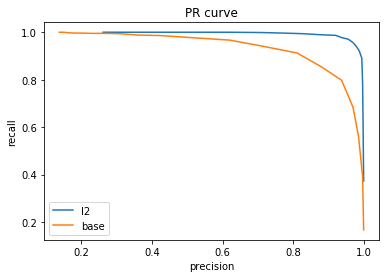

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure()

ax = fig.add_subplot(1,1,1)


ax.plot(precision,recall, label='l2')
ax.plot(baseprecision, baserecall, label='base')

ax.set_title('PR curve')
ax.set_xlabel('precision')
ax.set_ylabel('recall')
plt.legend()
fig.show()